In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
from scipy import stats
plt.style.use('seaborn-v0_8-darkgrid')
rcParams['figure.figsize'] = (12, 5)
rcParams['axes.titlesize'] = 14
rcParams['axes.labelsize'] = 12
rcParams['lines.linewidth'] = 1.5

np.random.seed(13)

print(f"[OK]")

[OK]


# **Bloque II — Fundamentos Cuantitativos**
---
## **3.1 Marco de Modelado del Mercado**
### *Diferencia entre el Proceso Generador y la Observación*
**Objetivo de la clase:** Entender la diferencia entre lo que **observamos** en el mercado (datos de precios) y el **modelo matemático** que asumimos como proceso generador subyacente.

**Estructura:**
1. **La Realidad** — Precios, retornos y por qué los quants trabajan con retornos logarítmicos.
2. **El Modelo Generador** — Movimiento Browniano Geométrico (GBM) como hipótesis del proceso subyacente.
3. **Realizaciones y Convergencia** — Simulación Monte Carlo: el modelo no predice un precio, sino una *distribución* de futuros posibles.

**"Todo modelo es una simplificación de la realidad, y es por eso que debemos entender lo que estamos observando."**

### **Los Precios**

Cuando descargamos o visualizamos datos del mercado, lo primero que vemos es una serie temporal de **precios** $P_t$. 

A primera vista, parece que tenemos información útil y suficiente tal cual como para predecir el futuro, pero una serie de precios como esta presenta problemas fundamentales para el análisis estadístico:

- **No son estacionarios:** la media y la varianza cambian con el tiempo.
- **Tienen tendencia:** es un problema porque invalida la media histórica como predictor. Al depender del tiempo, el valor esperado del precio mañana ($E[P_{t+1}]$) no tiene por qué parecerse al promedio de los últimos 10 años. Además, esto genera correlaciones falsas entre activos que simplemente comparten una tendencia alcista sin estar relacionados económicamente.
- **Dependen de la escala:** un precio de $100 no es comparable con uno de $1000. Un movimiento de $10 en una acción que vale $100 (10%) es drásticamente diferente a un movimiento de $10 en una que vale $1000 (1%). Es incomparable.

Esto hace que aplicar modelos estadísticos directamente sobre los precios no siempre sea válido...

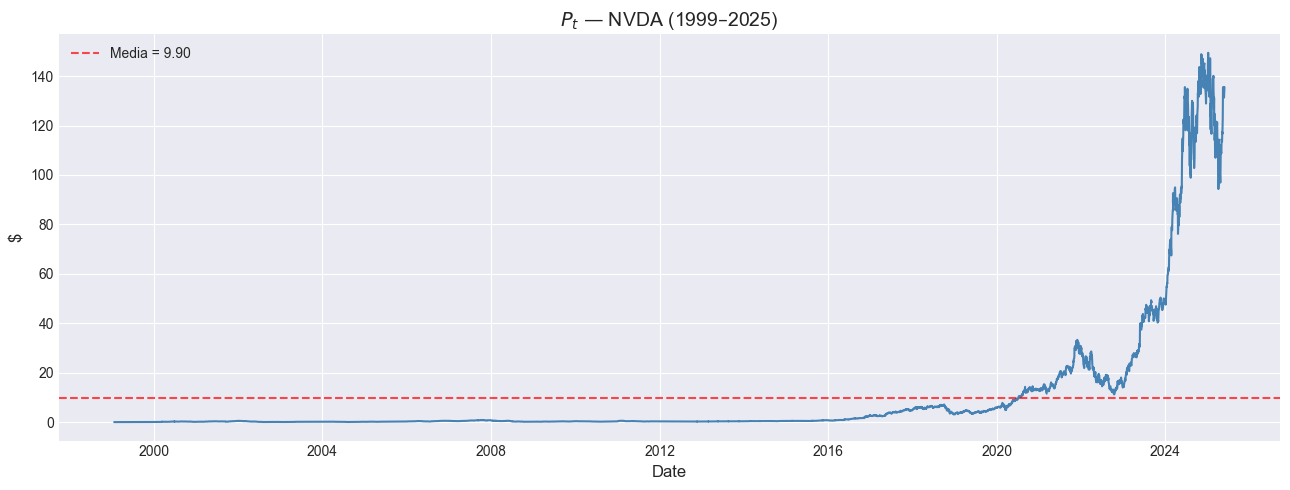

Observaciones: 6683
Precio inicial: $0.0400
Precio final: $135.50
Media: $9.90


In [3]:
#NVDA (1999–2025)
df = pd.read_csv('../data/NVDA_returns.csv', parse_dates=['Date'], thousands=',')
df = df.sort_values('Date').reset_index(drop=True)
df = df.rename(columns={'Adj Close': 'Precio'})
df = df[['Date', 'Precio']].set_index('Date')
prices = df['Precio'].values

fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(df.index, df['Precio'], color='steelblue', linewidth=1.5)
ax.set_title('$P_t$ — NVDA (1999–2025)', fontsize=14)
ax.set_xlabel('Date')
ax.set_ylabel('$')
ax.axhline(y=df['Precio'].mean(), color='red', linestyle='--', alpha=0.7, label=f'Media = {df["Precio"].mean():.2f}')
ax.legend()
plt.tight_layout()
plt.show()

print(f"Observaciones: {len(df)}")
print(f"Precio inicial: ${prices[0]:.4f}")
print(f"Precio final: ${prices[-1]:.2f}")
print(f"Media: ${df['Precio'].mean():.2f}")
# La media de los precios NO es un estadístico útil. Depende completamente del rango temporal que elijamos.

## De Precios a Retornos: En busca de la Estacionariedad

Ya hemos visto visualmente que los precios ($P_t$) tienen tendencia y una varianza que cambia con el tiempo. 
Esto viola el principio básico de la inferencia estadística; la **Estacionariedad**.

Para modelar, necesitamos transformar la serie en algo que tenga propiedades estables. Aquí es donde nacen los **Retornos**. Al calcular el cambio relativo, eliminamos la escala y la tendencia, quedándonos con la "dinámica" pura del activo.

Sin embargo, no todos los retornos son iguales. En finanzas tenemos dos opciones principales:
1.  **Retornos Simples:** $R_t = \frac{P_t - P_{t-1}}{P_{t-1}}$
2.  **Retornos Logarítmicos:** $r_t = \ln(\frac{P_t}{P_{t-1}})$

Pero cuál debemos usar?
---

## Retornos ¿Simples o Logarítmicos?

Aunque los retornos simples son intuitivos para el inversor (e.g "gané un 10%"), los **Retornos Logarítmicos ($r_t$)** son la herramienta estándar para el modelado cuantitativo por sus propiedades matemáticas.

$$
r_t = \ln(P_t) - \ln(P_{t-1})
$$

#### 1. Aditividad Temporal (Time Additivity)
Esta es la propiedad más crítica para modelar trayectorias a largo plazo.
* **Retornos Simples ($R_t$):** **No se suman.** Ganar un 10% hoy y un 10% mañana no es un 20% total.
* **Log-Returns ($r_t$):** **Son aditivos.** El log-retorno total de un año es exactamente la suma de los log(returns) diarios.

#### 2. Simetría Numérica
* **Retornos Simples:** Son asimétricos. Si una acción cae un 50%, necesita subir un 100% para volver al origen, lo cual sesga la media. (e.g pierdes 50% y luego ganas 100%, la suma aritmética es $+50\%$ (y la media $+25\%$), pero en realidad el beneficio = 0.)
* **Log-Returns:** Son simétricos, es decir, una caída de log-retorno $-0.693$ se compensa exactamente con una subida de $+0.693$.

#### 3. Normalidad y Dominio
Para usar la famosa distribución Normal oCampana de Gauss, la variable debe poder tomar cualquier valor entre $-\infty$ y $+\infty$.
* **El problema de los retornos simples** es que como los precios no pueden ser negativos, el retorno simple mínimo es $-1$ (-100%). Esto "trunca" la distribución por la izquierda, violando la asunción de normalidad.
* **Los retornos logarítmicos:** Como $\ln(0) \to -\infty$, los log(returns) permiten modelar teóricamente caídas infinitas, ajustándose mejor a la matemática de la Distribución Normal.

#### 4. Estacionariedad
Empíricamente, los log(returns) muestran una media y varianza más estables a lo largo del tiempo que los cambios porcentuales simples, lo que hace que los parámetros ($\mu, \sigma$) estimados hoy sean más fiables para proyecciones futuras.

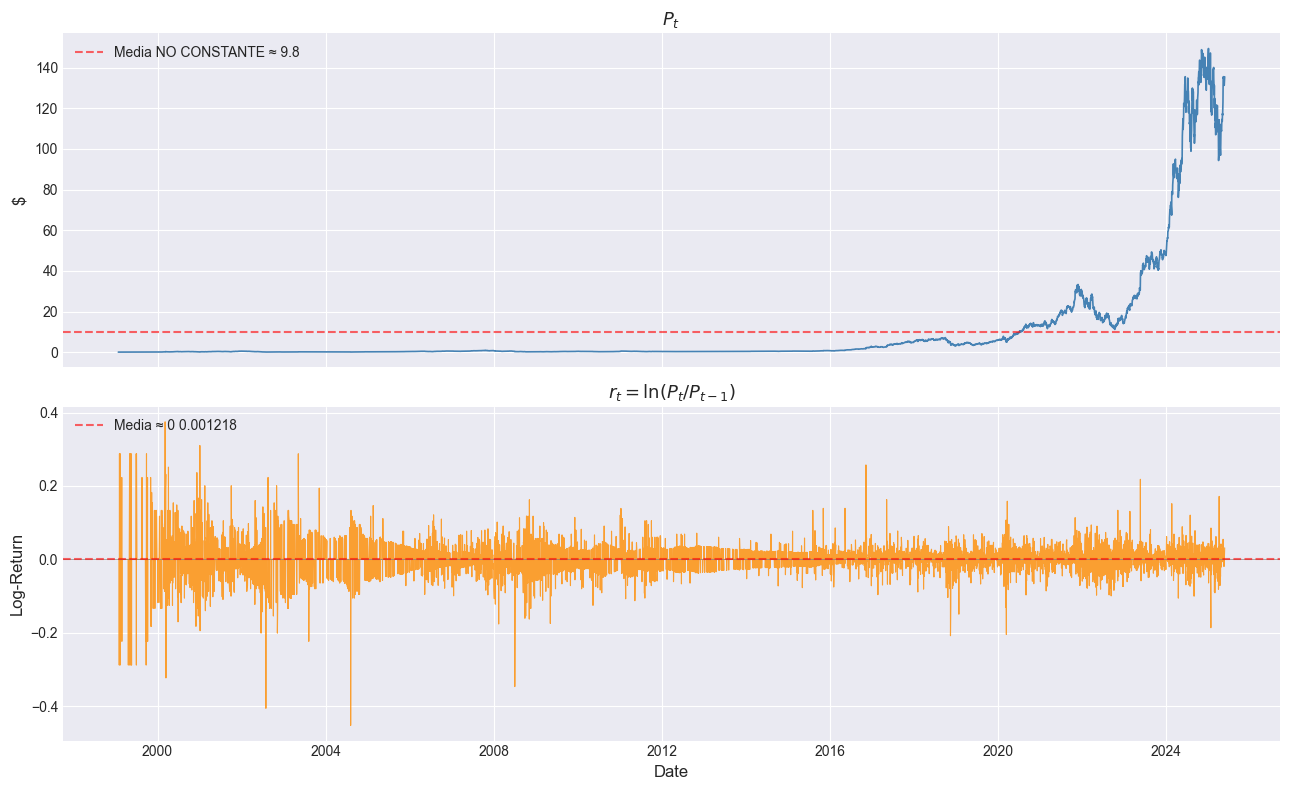

Estadísticas de los Daily Log(returns):
Media (μ diaria):0.001218
Desviación Estándar (σ):0.043422
Media anualizada:0.3070 (30.70%)
σ anualizada:0.6893 (68.93%)


In [4]:
# precios vs retornos logarítmicos 
df['Log_Return'] = np.log(df['Precio'] / df['Precio'].shift(1))
df.dropna(inplace=True) #se elimna primer nan porque se depende de ese anterior para caluclar


fig, axes = plt.subplots(2, 1, figsize=(13, 8), sharex=True)
axes[0].plot(df.index, df['Precio'], color='steelblue', linewidth=1.2)
axes[0].set_title('$P_t$', fontsize=13) #no estacionario
axes[0].set_ylabel('$')
axes[0].axhline(y=df['Precio'].mean(), color='red', linestyle='--', alpha=0.6,label=f'Media NO CONSTANTE ≈ {df["Precio"].mean():.1f}')
axes[0].legend(loc='upper left')

axes[1].plot(df.index, df['Log_Return'], color='darkorange', linewidth=0.8, alpha=0.8)
axes[1].axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
axes[1].axhline(y=df['Log_Return'].mean(), color='red', linestyle='--', alpha=0.6,label=f'Media ≈ 0 {df["Log_Return"].mean():.6f}')
axes[1].set_title(r'$r_t = \ln(P_t / P_{t-1})$', fontsize=13)#aproiximadamente estacionario
axes[1].set_ylabel('Log-Return')
axes[1].set_xlabel('Date')
axes[1].legend(loc='upper left')

plt.tight_layout()
plt.show()

print("Estadísticas de los Daily Log(returns):")
print(f"Media (μ diaria):{df['Log_Return'].mean():.6f}")
print(f"Desviación Estándar (σ):{df['Log_Return'].std():.6f}")
print(f"Media anualizada:{df['Log_Return'].mean() * 252:.4f} ({df['Log_Return'].mean() * 252 * 100:.2f}%)")
print(f"σ anualizada:{df['Log_Return'].std() * np.sqrt(252):.4f} ({df['Log_Return'].std() * np.sqrt(252) * 100:.2f}%)")

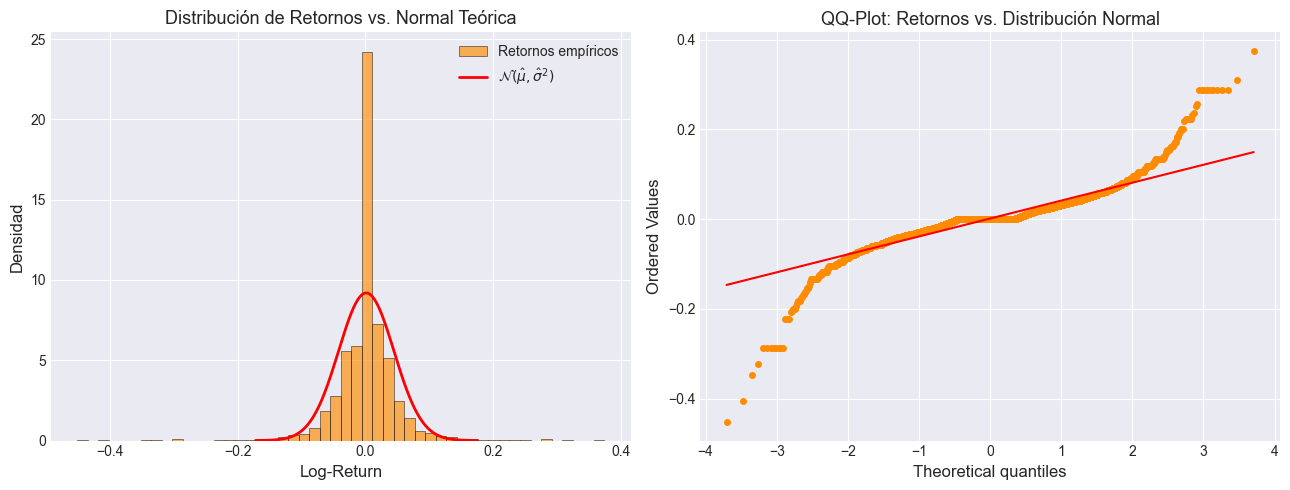

In [5]:
#Distribucion de los retornos

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
mu_hat  = df['Log_Return'].mean()# Media muestral
sig_hat = df['Log_Return'].std()# Desviación estándar muestral

x_grid = np.linspace(mu_hat - 4*sig_hat, mu_hat + 4*sig_hat, 200)
normal_pdf = (1 / (sig_hat * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x_grid - mu_hat) / sig_hat)**2)

axes[0].hist(df['Log_Return'], bins=50, density=True, alpha=0.65, color='darkorange', edgecolor='black', linewidth=0.5, label='Retornos empíricos')
axes[0].plot(x_grid, normal_pdf, 'r-', linewidth=2, label=f'$\\mathcal{{N}}(\\hat{{\\mu}}, \\hat{{\\sigma}}^2)$')
axes[0].set_title('Distribución de Retornos vs. Normal Teórica', fontsize=13)
axes[0].set_xlabel('Log-Return')
axes[0].set_ylabel('Densidad')
axes[0].legend()


stats.probplot(df['Log_Return'], dist='norm', plot=axes[1])
axes[1].set_title('QQ-Plot: Retornos vs. Distribución Normal', fontsize=13)
axes[1].get_lines()[0].set_color('darkorange')
axes[1].get_lines()[0].set_markersize(4)

plt.tight_layout()
plt.show()
#los retornos se PARECEN a ruido Gaussiano aunque las colas son más pesadas (fat tails) en datos reales.
#Esta similitud es la base para asumir un modelo Normal → GBM.

Hemos transformado precios en log(returns) para buscar estacionariedad, pero para usar modelos matemáticos estándar (como Black-Scholes o el Movimiento Browniano), necesitamos algo más: que esos retornos sigan una **Distribución Normal**.

#### Histograma
Comparamos la frecuencia de los retornos reales de NVDA (barras naranjas) contra la curva teórica Normal (línea roja) generada con la media y desviación estándar de los datos.
* La forma general es de campana, pero hay diferencias claras: el pico central es **mucho más agudo** que el de la Normal teórica, y las colas se extienden más de lo que la Normal predice. Esto se llama **leptocurtosis** (exceso de curtosis) y es una propiedad universal de los retornos financieros reales.
* A pesar de estas diferencias, la forma general sigue siendo simétrica y centrada en torno a 0, lo cual hace que la asunción de normalidad sea una aproximación razonable como punto de partida, aunque imperfecta.

#### Quantile-Quantile Graph
El histograma a veces engaña, y por eso usaremos este otro gráfico.
* **Eje X:** Dónde *deberían* estar los datos si la distribución fuera perfectamente Normal.
* **Eje Y:** Dónde *están* realmente los datos.
* **Línea Roja:** La perfección. Si los puntos siguen la línea, los datos son normales.

1.  **En el centro (entre -1 y +1),** los puntos se pegan razonablemente a la línea roja, por lo que para los días "normales", el modelo Normal funciona.
2.  **En los extremos (tails),** las desviaciones son dramáticas. Los puntos se despegan claramente de la línea a partir de ±2 desviaciones estándar.
    * Esto confirma las **Fat Tails**: en la realidad, NVDA ha tenido caídas de -40% y subidas de +30% en un solo día, por lo que eventos que bajo la distribución Normal serían prácticamente imposibles (probabilidad < $10^{-20}$).
    * Esta es **la limitación más importante del GBM** que asumiremos: el modelo subestima la frecuencia de eventos extremos, y aun así, es el punto de partida estándar en quantitive finance.

Hasta aquí hemos establecido un hecho  fundamental:

--> **Los retornos logarítmicos de los activos financieros se comportan *aproximadamente* como ruido Gaussiano independiente.**

Esto debería llevarnos a otra pregunta:

--> *Si los retornos parecen normales, **¿podemos construir un modelo matemático que genere precios con esta propiedad?***

## Modelo Generador: **Movimiento Browniano Geométrico**

### Movimiento Browniano

Un **Movimiento Browniano Estándar** $\{W_t\}_{t \geq 0}$ es un proceso estocástico con las siguientes propiedades:

1. $W_0 = 0$, es decir, la acumulación de ruido empieza desde cero en el momento de nuestra primera observación. (no hay ruido acumulado al inicar).
2. **Incrementos independientes:** para $0 \leq s < t$, el incremento $W_t - W_s$ es independiente de la historia hasta el tiempo $s$. (No hay memoria).
3. **Incrementos normales:** $W_t - W_s \sim \mathcal{N}(0,\; t - s)$ (Se sigue distribución normal).
4. Las trayectorias $t \mapsto W_t$ son **continuas** (pero en ningún punto diferenciables).
    Ojo con esto último, decimos que las trayectorias son continuas, es decir, antes de pasar a 100.02 el precio debe pasar por 100.01 y viceversa. Decimos que en ningún punto son estas trayectorias diferenciables porque no importa cuánto aumentemos dentro de estos pasos en las trayectorias, que el precio no se ve suave, es un fractal. Y claro, lo que nos dice la intuición es que para que sea diferenciable, llega un punto que cuando hacemos suficiente "zoom" a una curva, llega un punto en el que termina pareciendo una línea recta, esa es la derivada. Claro, si no hay recta, no es tangente, no hay derivada.

El Movimiento Browniano es fundamental porque representa ruido puro, y es la fuente de aleatoriedad en los modelos financieros.

### La Ecuación Diferencial Estocástica (SDE) del GBM
Si asumimos que los retornos logarítmicos son normales e independientes, el precio $S_t$ sigue un **Movimiento Browniano Geométrico**, definido por la SDE:

$$
\boxed{dS_t = \underbrace{\mu \, S_t \, dt}_{\text{Drift}} + \underbrace{\sigma \, S_t \, dW_t}_{\text{Difusión}}}
$$

donde:

- **Drift** ($\mu S_t \, dt$): Es la tendencia. Si el ruido fuera cero, el precio crecería como una cuenta de ahorros constante.
- **La Difusión** ($\sigma S_t \, dW_t$): Depende de la volatilidad ($\sigma$) y del motor de ruido ($dW_t$).
- **¿Por qué aparece $S_t$ en ambos lados?** Significa que el movimiento es **porcentual**. Si la acción vale $100, un movimiento del 1% es $1. Si vale $1000, es $10. El modelo crece proporcionalmente al precio.

---

### ¿Por qué el cálculo tradicional no funciona aquí?

En el cálculo que aprendemos normalmente (Newton), si una variable crece a una tasa $\mu$, su valor simplemente sigue una exponencial $e^{\mu t}$. Sin embargo, en el mundo financiero existe un fenómeno llamado **Volatility Drag**.

#### Volatility Drag

Imagina que tienes 100 €.
- **Día 1 (Caída):** Pierdes un 50%. Ahora tienes 50 €.
- **Día 2 (Recuperación):** Ganas un 50%. Pero ese 50% se aplica sobre los 50 € que te quedan, dándote solo **75 €**.

A pesar de que la suma de los retornos parece ser cero ($+50\% - 50\% = 0$), has perdido el **25%** de tu dinero. La volatilidad "se ha comido" parte de tu capital.

#### El Lema de Itô
Es la herramienta que nos permite "traducir" lo que pasa con los retornos hacia lo que pasa con el precio final, teniendo en cuenta este lastre de la volatilidad.

En el cálculo estocástico, el ruido ($dW_t$) es tan "rugoso" (no diferenciable) que sus variaciones al cuadrado **no desaparecen**. Mientras que en el cálculo normal $(dx)^2 = 0$, en el mundo de Itô se cumple que:

$$(dW_t)^2 = dt$$

Al aplicar el Lema de Itô para resolver la ecuación diferencial estocástica (SDE) del precio, aparece el término $-\frac{1}{2}\sigma^2$:

$$
\boxed{S_t = S_0 \cdot \exp\!\left[\left(\mu - \tfrac{1}{2}\sigma^2\right)t + \sigma \, W_t\right]}
$$

- **Sin el Lema de Itô:** Estaríamos asumiendo que el dinero crece a tasa $\mu$, ignorando que las subidas y bajadas nos empobrecen poco a poco.
- **Con el Lema de Itô:** El modelo resta ese "impuesto" de volatilidad ($-\frac{1}{2}\sigma^2$) de forma automática. Es la corrección matemática que asegura que el modelo sea fiel a la realidad del interés compuesto en mercados volátiles.

> El Lema de Itô es al cálculo estocástico lo que la Regla de la Cadena es al cálculo normal, pero con un ajuste extra para que la volatilidad no nos mienta sobre el rendimiento real a largo plazo.

Parámetros estimados de los datos reales (NVDA):
μ (drift anualizado) = 0.3070  (30.70%)
σ (volatilidad anualizada) = 0.6893  (68.93%)
S₀ (precio hace ~1 año) = $94.33
Pasos de simulación (N)= 252


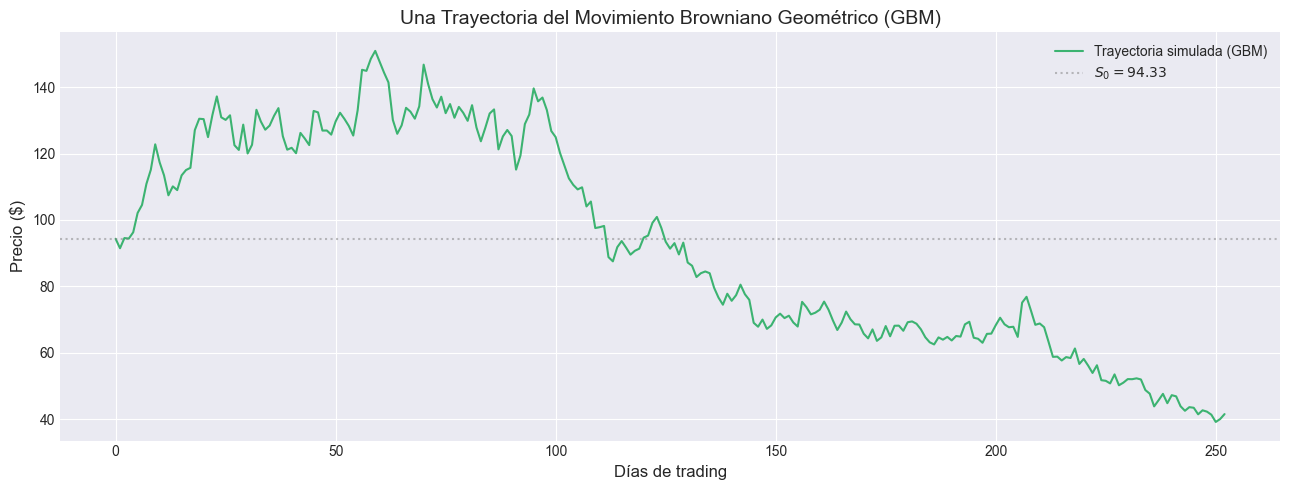

 Precio final de esta simulación: $41.51
   Retorno total: -56.00%


In [6]:
#simulation_1 trayectoria GBM

mu_anual = df['Log_Return'].mean() * 252
sigma_anual = df['Log_Return'].std() * np.sqrt(252)

# Usamos el precio de hace ~1 año como punto de partida
# Así podremos superponer el último año real sobre las simulaciones
S0_sim = df['Precio'].iloc[-253]
T_sim = 1.0
dt_sim = 1/252
N_sim = int(T_sim / dt_sim)

print(f"Parámetros estimados de los datos reales (NVDA):")
print(f"μ (drift anualizado) = {mu_anual:.4f}  ({mu_anual*100:.2f}%)")
print(f"σ (volatilidad anualizada) = {sigma_anual:.4f}  ({sigma_anual*100:.2f}%)")
print(f"S₀ (precio hace ~1 año) = ${S0_sim:.2f}")
print(f"Pasos de simulación (N)= {N_sim}")

# En cada paso dt:
#   ln(S_{t+dt}) = ln(S_t) + (μ - σ²/2)·dt + σ·√dt·Z donde Z ~ N(0,1)

Z_sim = np.random.standard_normal(N_sim)  # Innovaciones normales estándar

# Incrementos del log-precio
d_log_S = (mu_anual - 0.5 * sigma_anual**2) * dt_sim + sigma_anual * np.sqrt(dt_sim) * Z_sim

# Trayectoria de log-precios: acumular incrementos
log_S = np.concatenate([[np.log(S0_sim)], np.log(S0_sim) + np.cumsum(d_log_S)])

# Precios: exponenciar
S_sim = np.exp(log_S)

# Eje temporal en días de trading
t_days = np.arange(len(S_sim))

# -- Graficar la trayectoria simulada --
fig, ax = plt.subplots(figsize=(13, 5))
ax.plot(t_days, S_sim, color='mediumseagreen', linewidth=1.5, label='Trayectoria simulada (GBM)')
ax.axhline(y=S0_sim, color='gray', linestyle=':', alpha=0.5, label=f'$S_0 = {S0_sim:.2f}$')
ax.set_title('Una Trayectoria del Movimiento Browniano Geométrico (GBM)', fontsize=14)
ax.set_xlabel('Días de trading')
ax.set_ylabel('Precio ($)')
ax.legend()
plt.tight_layout()
plt.show()

print(f" Precio final de esta simulación: ${S_sim[-1]:.2f}")
print(f"   Retorno total: {(S_sim[-1]/S0_sim - 1)*100:.2f}%")

### ¿El modelo reproduce la realidad?

Si el GBM fuera un buen modelo generador, los retornos de la trayectoria simulada deberían tener propiedades estadísticas similares a los retornos reales que observamos al principio.
Verifiquemos esto comparando ambas distribuciones lado a lado.

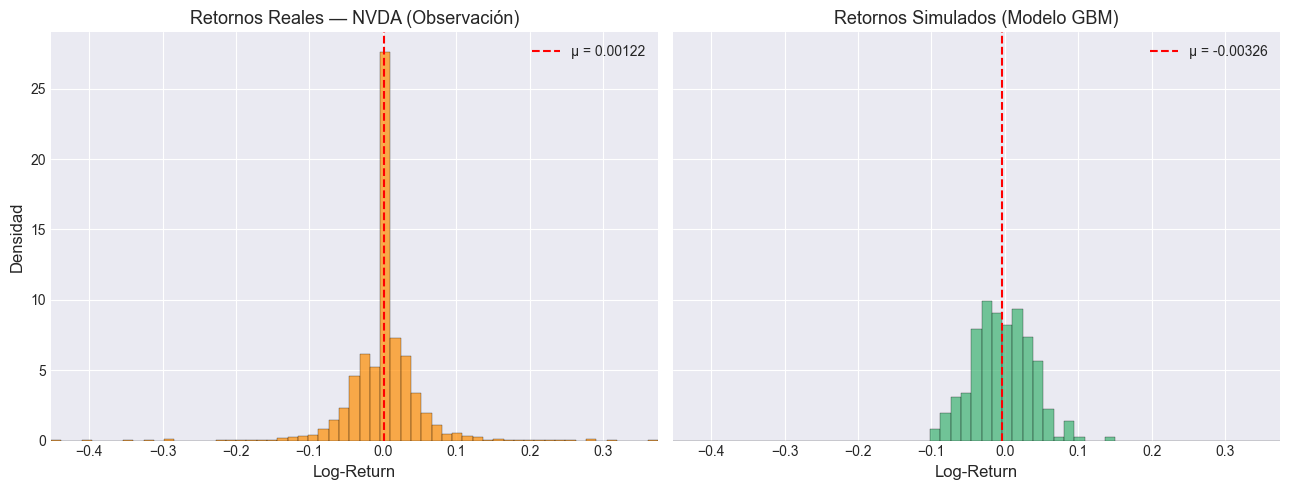

 Comparación de momentos:
                            Observados     Simulados
             Media diaria     0.001218     -0.003257
    Desv. Estándar diaria     0.043422      0.039729
                 Curtosis        12.98          0.35


In [7]:
# Retornos logarítmicos de la trayectoria simulada
sim_log_returns = np.diff(log_S)  # Equivalente a ln(S_{t+1}/S_t)

# Mismos bins y límites para comparación honesta (apples to apples)
x_min = min(df['Log_Return'].min(), sim_log_returns.min())
x_max = max(df['Log_Return'].max(), sim_log_returns.max())
shared_bins = np.linspace(x_min, x_max, 60)

fig, axes = plt.subplots(1, 2, figsize=(13, 5), sharey=True)

axes[0].hist(df['Log_Return'], bins=shared_bins, density=True, alpha=0.7,
             color='darkorange', edgecolor='black', linewidth=0.3)
axes[0].set_title('Retornos Reales — NVDA (Observación)', fontsize=13)
axes[0].set_xlabel('Log-Return')
axes[0].set_ylabel('Densidad')
axes[0].set_xlim(x_min, x_max)
axes[0].axvline(x=df['Log_Return'].mean(), color='red', linestyle='--',
                label=f'μ = {df["Log_Return"].mean():.5f}')
axes[0].legend()

axes[1].hist(sim_log_returns, bins=shared_bins, density=True, alpha=0.7,
             color='mediumseagreen', edgecolor='black', linewidth=0.3)
axes[1].set_title('Retornos Simulados (Modelo GBM)', fontsize=13)
axes[1].set_xlabel('Log-Return')
axes[1].set_xlim(x_min, x_max)
axes[1].axvline(x=sim_log_returns.mean(), color='red', linestyle='--',
                label=f'μ = {sim_log_returns.mean():.5f}')
axes[1].legend()

plt.tight_layout()
plt.show()

print(" Comparación de momentos:")
print(f"{'':>25} {'Observados':>12}  {'Simulados':>12}")
print(f"{'Media diaria':>25} {df['Log_Return'].mean():>12.6f}  {sim_log_returns.mean():>12.6f}")
print(f"{'Desv. Estándar diaria':>25} {df['Log_Return'].std():>12.6f}  {sim_log_returns.std():>12.6f}")
print(f"{'Curtosis':>25} {df['Log_Return'].kurtosis():>12.2f}  {pd.Series(sim_log_returns).kurtosis():>12.2f}")
#la curtosis de los datos reales es mucho mayor que la del GBM (~0),confirmando las fat tails que vimos en el QQ-plot.

### La Mentira de la Distribución Normal

Al comparar los histogramas con la misma escala, descubrimos una verdad incómoda sobre el modelo GBM:

1.  **Volatilidad:**
    Observando la desviación estándar ($\sigma \approx 0.04$), el modelo ha replicado perfectamente la "anchura" general de la distribución. Para el día a día, el modelo funciona.

2.  **Curtosis y Colas:**
    ->métrica de **Curtosis**:
    * **Simulado (0.08):** El modelo GBM genera una campana suave y perfecta. Dice que los eventos extremos son imposibles.
    * **Realidad (12.98):** La realidad es "Leptocúrtica".
        * **El Pico:** El mercado es mucho más aburrido de lo normal (el pico naranja en el centro es altísimo).
        * **Las Colas:** El mercado es mucho más peligroso de lo normal (hay barras naranjas en -0.3 y -0.4).

> **Conclusión:**
> El Movimiento Browniano Geométrico es un modelo **útil pero incompleto**.
> * Es excelente para capturar la tendencia y la volatilidad media.
> * Es terrible prediciendo crisis. En la gráfica simulada, el peor día fue un -10%. En la realidad, hubo días de -30% o -40%.

## Simulación Monte Carlo

> *"Una sola trayectoria no nos dice nada del futuro. No sabemos qué camino tomará el mercado, pero podemos estimar la distribución de caminos posibles."*

### 3.1 La Idea de Monte Carlo

El modelo GBM define un **proceso generador de datos**. Cada vez que lo "corremos", obtenemos una *realización* diferente, un camino posible que el mercado *podría* tomar.

La **Simulación Monte Carlo** consiste en generar un número grande $M$ de trayectorias independientes del mismo modelo, para aproximar la **distribución de probabilidad** de los resultados futuros.

Esto es posible gracias a la **Ley de los Grandes Números (LLN):**

$$
\frac{1}{M} \sum_{i=1}^{M} g\!\left(S_T^{(i)}\right) \xrightarrow{M \to \infty} \mathbb{E}\!\left[g(S_T)\right]
$$

Es decir: el promedio muestral de cualquier función $g(S_T)$ sobre $M$ simulaciones **converge** al valor esperado teórico conforme $M$ crece.

### Implementación: 1,000 Trayectorias

In [8]:
# Monte Carlo Simulation 1000 trayectoriess of GBM

M = 1000
N_mc = 252
dt_mc = 1/252

Z_mc = np.random.standard_normal((M, N_mc))
d_logS_mc = (mu_anual - 0.5 * sigma_anual**2) * dt_mc + sigma_anual * np.sqrt(dt_mc) * Z_mc
logS_mc = np.log(S0_sim) + np.cumsum(d_logS_mc, axis=1)
logS_mc = np.hstack([np.full((M, 1), np.log(S0_sim)), logS_mc])

S_mc = np.exp(logS_mc)
t_mc = np.arange(N_mc + 1)

print(f"Generadas {M:,} trayectorias de {N_mc} pasos cada una.")
print(f"Matriz de precios: {S_mc.shape} (trayectorias × pasos)")
print(f"Precio inicial en todas: ${S_mc[0, 0]:.2f}")
print(f"Rango de precios finales: [${S_mc[:, -1].min():.2f}, ${S_mc[:, -1].max():.2f}]")

Generadas 1,000 trayectorias de 252 pasos cada una.
Matriz de precios: (1000, 253) (trayectorias × pasos)
Precio inicial en todas: $94.33
Rango de precios finales: [$14.36, $1708.46]


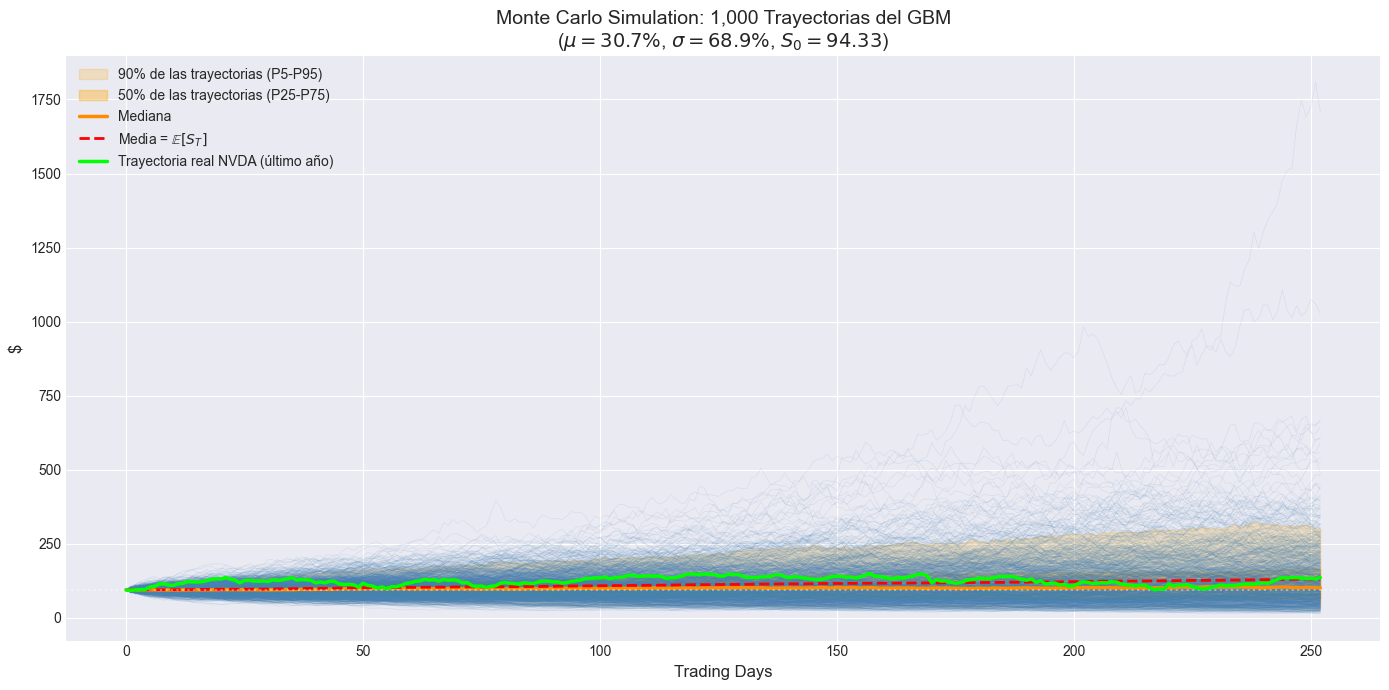

In [9]:
fig, ax = plt.subplots(figsize=(14, 7))

for i in range(M):
    ax.plot(t_mc, S_mc[i, :], color='steelblue', alpha=0.12, linewidth=0.5)
p5   = np.percentile(S_mc, 5,  axis=0)   # Percentil 5%
p25  = np.percentile(S_mc, 25, axis=0)   # Percentil 25%
p50  = np.percentile(S_mc, 50, axis=0)   # Mediana
p75  = np.percentile(S_mc, 75, axis=0)   # Percentil 75%
p95  = np.percentile(S_mc, 95, axis=0)   # Percentil 95%
mean_path = np.mean(S_mc, axis=0)         # Media

ax.fill_between(t_mc, p5, p95, alpha=0.2, color='orange', label='90% de las trayectorias (P5-P95)')
ax.fill_between(t_mc, p25, p75, alpha=0.35, color='orange', label='50% de las trayectorias (P25-P75)')

ax.plot(t_mc, p50, color='darkorange', linewidth=2.5, linestyle='-', label='Mediana')
ax.plot(t_mc, mean_path, color='red', linewidth=2.0, linestyle='--', label=f'Media = $\\mathbb{{E}}[S_T]$')

# trayectoria REAL de NVDA superpuesta
real_last_year = df['Precio'].values[-253:]
n_overlay = min(N_mc + 1, len(real_last_year))
ax.plot(t_mc[:n_overlay], real_last_year[:n_overlay], color='lime', linewidth=2.5,label='Trayectoria real NVDA (último año)', zorder=5)
#linea preico inicial
ax.axhline(y=S0_sim, color='white', linestyle=':', alpha=0.4)

ax.set_title(f'Monte Carlo Simulation: {M:,} Trayectorias del GBM\n'f'($\\mu = {mu_anual*100:.1f}\\%$, $\\sigma = {sigma_anual*100:.1f}\\%$, $S_0 = {S0_sim:.2f}$)', fontsize=14)
ax.set_xlabel('Trading Days')
ax.set_ylabel('$')
ax.legend(loc='upper left', fontsize=10)
plt.tight_layout()
plt.show()

### $S_T$

El GBM produce precios **log-normalmente** distribuidos. Es decir:

$$
\ln S_T \sim \mathcal{N}\!\left(\ln S_0 + \left(\mu - \tfrac{1}{2}\sigma^2\right)T,\;\; \sigma^2 T\right)
$$

Por tanto, $S_T$ sigue una distribución **log-normal**. Veamos cómo se distribuyen los 1,000 precios finales.

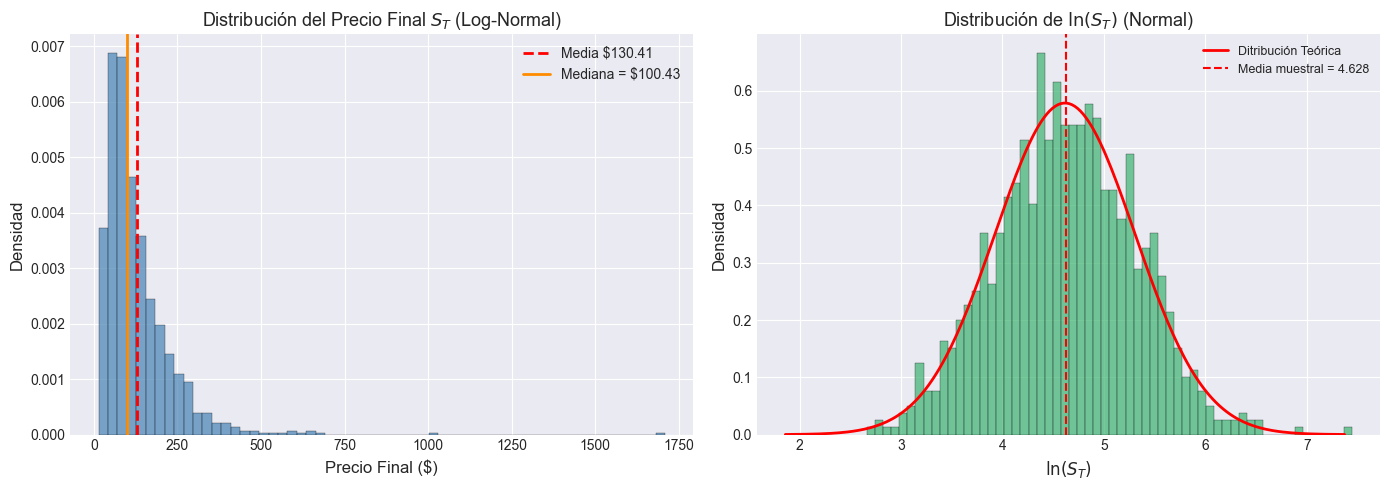

In [10]:
# Distribución del precio final S_T

S_T_all = S_mc[:, -1]  # Precios finales de las M trayectorias

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
axes[0].hist(S_T_all, bins=60, density=True, alpha=0.7,color='steelblue', edgecolor='black', linewidth=0.3)
axes[0].axvline(x=np.mean(S_T_all), color='red', linestyle='--', linewidth=2,label=f'Media ${np.mean(S_T_all):.2f}')
axes[0].axvline(x=np.median(S_T_all), color='darkorange', linestyle='-', linewidth=2,label=f'Mediana = ${np.median(S_T_all):.2f}')
axes[0].set_title('Distribución del Precio Final $S_T$ (Log-Normal)', fontsize=13)
axes[0].set_xlabel('Precio Final ($)')
axes[0].set_ylabel('Densidad')
axes[0].legend(fontsize=10)
logS_T_all = np.log(S_T_all)
axes[1].hist(logS_T_all, bins=60, density=True, alpha=0.7,color='mediumseagreen', edgecolor='black', linewidth=0.3)
mu_logST  = np.log(S0_sim) + (mu_anual - 0.5 * sigma_anual**2) * T_sim
sig_logST = sigma_anual * np.sqrt(T_sim)
x_norm = np.linspace(mu_logST - 4*sig_logST, mu_logST + 4*sig_logST, 200)
pdf_norm = (1/(sig_logST * np.sqrt(2*np.pi))) * np.exp(-0.5*((x_norm - mu_logST)/sig_logST)**2)
axes[1].plot(x_norm, pdf_norm, 'r-', linewidth=2,label=f'Ditribución Teórica')
axes[1].axvline(x=np.mean(logS_T_all), color='red', linestyle='--', linewidth=1.5,label=f'Media muestral = {np.mean(logS_T_all):.3f}')
axes[1].set_title('Distribución de $\\ln(S_T)$ (Normal)', fontsize=13)
axes[1].set_xlabel('$\\ln(S_T)$')
axes[1].set_ylabel('Densidad')
axes[1].legend(fontsize=9)

plt.tight_layout()
plt.show()

### Convergencia de Monte Carlo

Uno de los resultados más importantes: conforme aumentamos el número de simulaciones $M$, el promedio de los precios finales **converge** al valor esperado teórico.

Para el GBM, el valor esperado teórico del precio final es:

$$
\mathbb{E}[S_T] = S_0 \cdot e^{\mu T}
$$

Verifiquemos que nuestras simulaciones convergen a este valor.

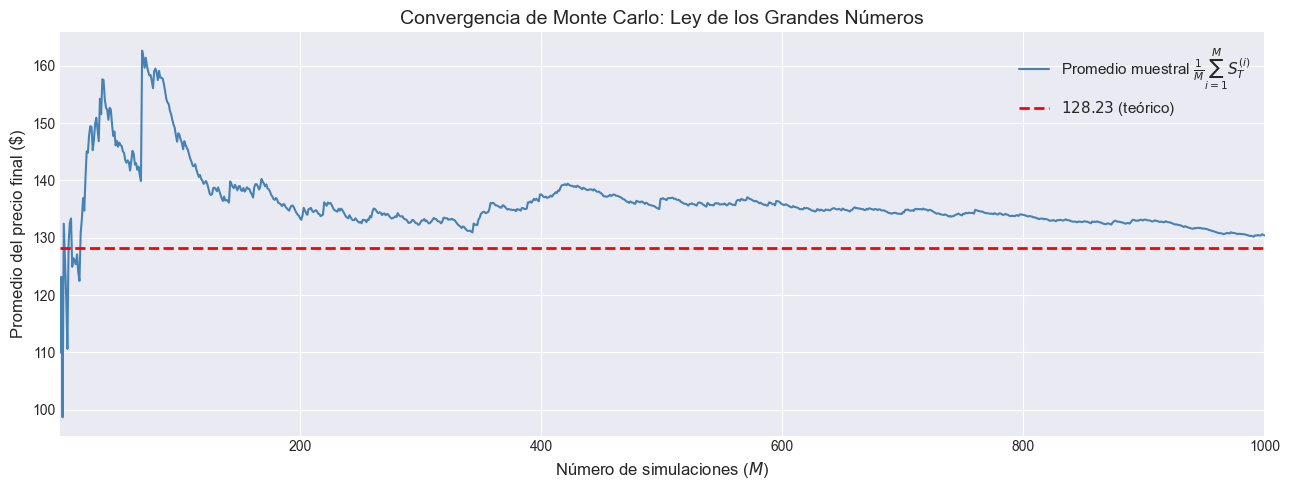

 Valor esperado teórico: $128.23
   Promedio Monte Carlo (M=1,000):  $130.41
   Error relativo: 1.694%
 La LLN garantiza que este error → 0 cuando M → ∞


In [11]:
# Convergencia de Monte Carlo: E[S_T] vs promedio muestral

# Valor esperado teórico del precio final bajo GBM
E_ST_teorico = S0_sim * np.exp(mu_anual * T_sim)

# Promedio acumulado conforme añadimos más simulaciones
cumulative_mean = np.cumsum(S_T_all) / np.arange(1, M + 1)

fig, ax = plt.subplots(figsize=(13, 5))

ax.plot(np.arange(1, M + 1), cumulative_mean, color='steelblue', linewidth=1.5, label='Promedio muestral $\\frac{1}{M}\\sum_{i=1}^{M} S_T^{(i)}$')
ax.axhline(y=E_ST_teorico, color='red', linestyle='--', linewidth=2, label=f'${E_ST_teorico:.2f}$ (teórico)')
ax.set_title('Convergencia de Monte Carlo: Ley de los Grandes Números', fontsize=14)
ax.set_xlabel('Número de simulaciones ($M$)')
ax.set_ylabel('Promedio del precio final ($)')
ax.legend(fontsize=11)
ax.set_xlim([1, M])
plt.tight_layout()
plt.show()

print(f" Valor esperado teórico: ${E_ST_teorico:.2f}")
print(f"   Promedio Monte Carlo (M={M:,}):  ${cumulative_mean[-1]:.2f}")
print(f"   Error relativo: {abs(cumulative_mean[-1] - E_ST_teorico) / E_ST_teorico * 100:.3f}%")
print(f" La LLN garantiza que este error → 0 cuando M → ∞")